# Deep Learning Project 1 - MLPs and CNN for image classification
> **MSc in Data Science, AUEB**<br />
> Giogiakas Sotirios ( *p3352204* ) <br />
> Sakkis Panagiotis ( *p3352222* ) 


## CIFAR-10 Dataset

Imports

In [40]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import cifar10
from keras.models import Model

print(tf.__version__)

2.15.0


In [4]:
random_seed = 42
random.seed(random_seed)
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Helper Functions

In [5]:
def plot_image(i, predictions, true_labels, img, class_names):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

In [6]:
def plot_value_array(i, predictions, true_labels, class_names, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [7]:
def plot_training_curves(training_history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()

### Import CIFAR-10 dataset

In [8]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

170498071/170498071 [==============================] - 6s 0us/step


Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


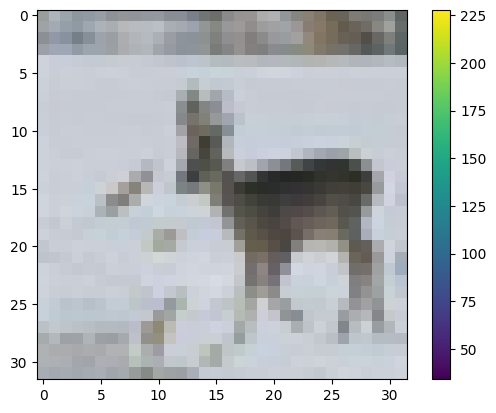

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [9]:
# Print the shape of the datasets
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)


# Visualize the first image from the training set
plt.figure()
plt.imshow(x_train[20])
plt.colorbar()
plt.grid(False)
plt.show()

# Print the shape of the datasets
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

In [10]:
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = y_train.flatten()
y_test = y_test.flatten()

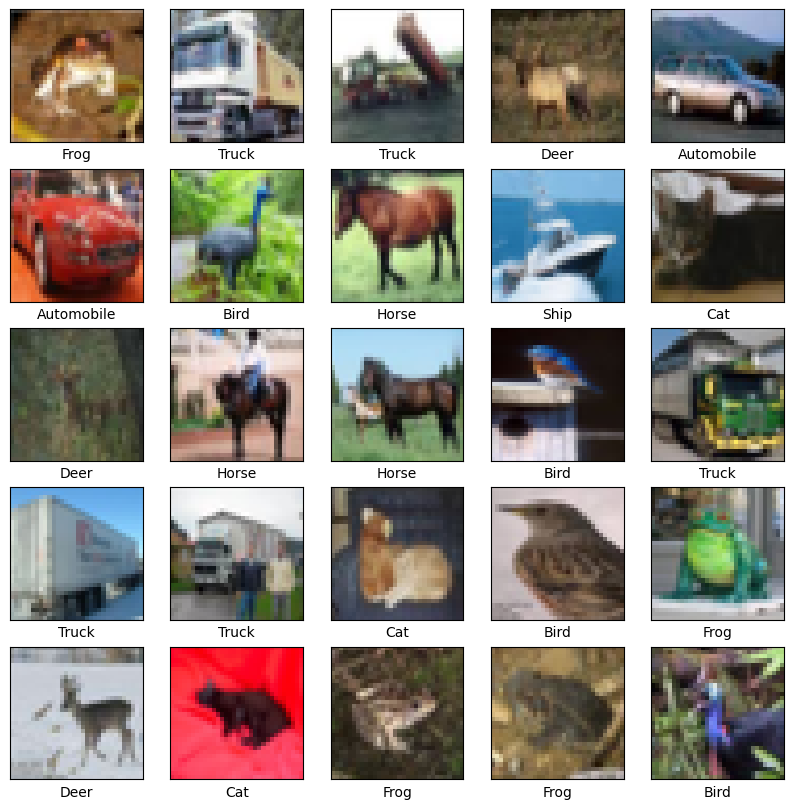

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.show()

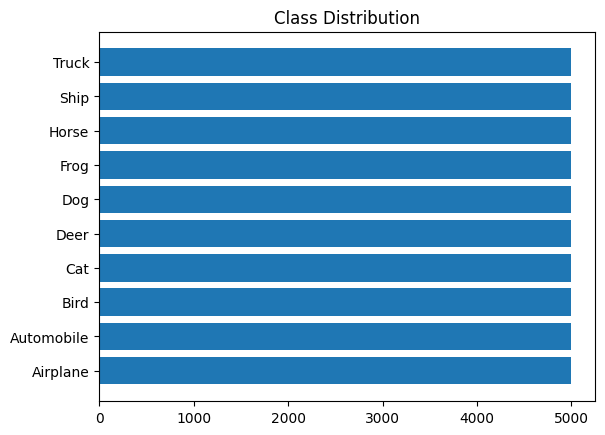

In [12]:
counts = np.bincount(y_train)

uniques = np.unique(y_train)

plt.barh(uniques, counts, align='center')
plt.yticks(uniques, class_names)
plt.title('Class Distribution')
plt.show()

### MLP

In [13]:
def build_model_cifar(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    layer_index = 0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=2)):
        if layer_index == 0:
            model.add(
                tf.keras.layers.Dense(
                    units=hp.Int('units', min_value=512, max_value=4096, step=512),
                    kernel_initializer='glorot_uniform',
                    activation='relu')
                    )
            model.add(tf.keras.layers.Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2])))
        else:
            model.add(
                tf.keras.layers.Dense(
                    units=hp.Int(name='hidden_units_'+str(i),min_value=64 ,max_value=512, step=64),
                    kernel_initializer='glorot_uniform',
                    activation='relu')
            )
            model.add(tf.keras.layers.Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2])))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(tf.keras.layers.Dense(len(class_names),  activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.001, 0.0001, or 0.00001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 2e-5])

    # Now compile your model with previous param
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [14]:
tuner = kt.Hyperband(build_model_cifar,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     seed=42,
                     project_name='deep_lr_cifar')

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 00m 53s]
val_accuracy: 0.47870001196861267

Best val_accuracy So Far: 0.49869999289512634
Total elapsed time: 00h 15m 50s


In [17]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 2,
 'units': 1536,
 'dropout_layer_0': 0.1,
 'learning_rate': 0.0001,
 'hidden_units_1': 448,
 'dropout_layer_1': 0.1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [18]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8702 - accuracy: 0.3268 - val_loss: 1.7434 - val_accuracy: 0.3790
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6926 - accuracy: 0.3943 - val_loss: 1.7021 - val_accuracy: 0.3951
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6096 - accuracy: 0.4277 - val_loss: 1.5839 - val_accuracy: 0.4406
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5552 - accuracy: 0.4427 - val_loss: 1.5592 - val_accuracy: 0.4472
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5016 - accuracy: 0.4666 - val_loss: 1.5163 - val_accuracy: 0.4647
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4600 - accuracy: 0.4790 - val_loss: 1.5227 - val_accuracy: 0.4542
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4266 - accuracy: 0.4927 - val_loss: 1.4711 - val_accuracy:

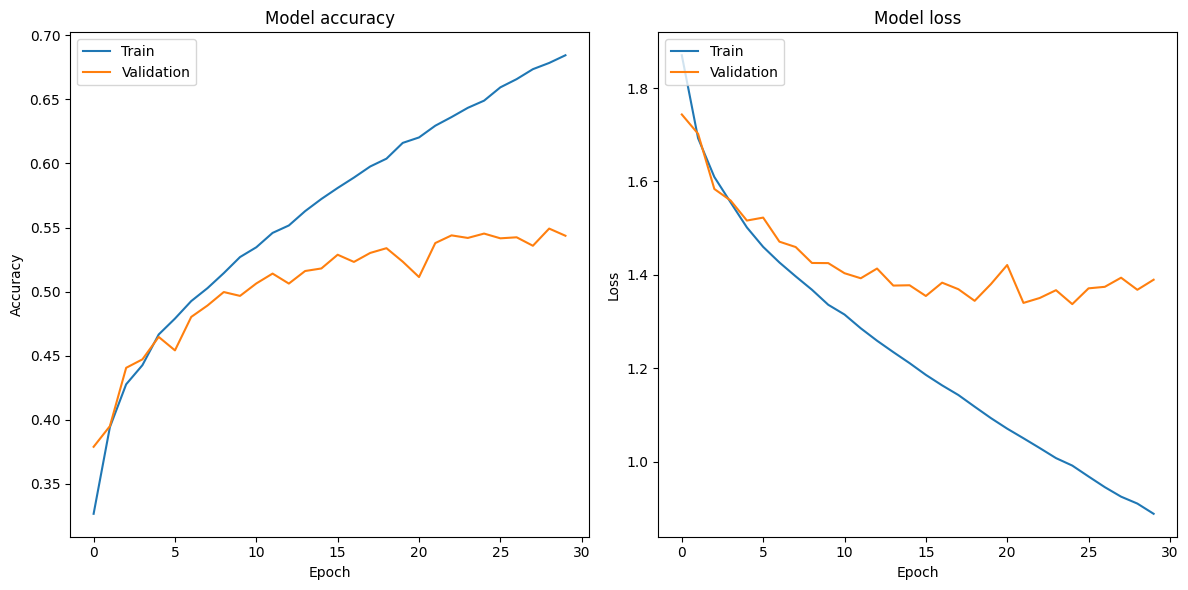

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [42]:
model.save("cifar_mlp_best_model.h5")

In [43]:
# test the model on testing data
eval_result = model.evaluate(x_test, y_test, verbose = 1)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 1.3669 - accuracy: 0.5393
[test loss, test accuracy]: [1.3669157028198242, 0.5393000245094299]


In [ ]:
# predictions = np.argmax(model.predict(X_test), -1)
predictions = model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions,-1), target_names=class_names))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    Airplane       0.65      0.54      0.59      1000
  Automobile       0.70      0.61      0.65      1000
        Bird       0.44      0.45      0.44      1000
         Cat       0.34      0.46      0.39      1000
        Deer       0.55      0.35      0.43      1000
         Dog       0.52      0.30      0.39      1000
        Frog       0.51      0.70      0.59      1000
       Horse       0.61      0.63      0.62      1000
        Ship       0.70      0.64      0.67      1000
       Truck       0.52      0.71      0.60      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.54     10000
weighted avg       0.55      0.54      0.54     10000



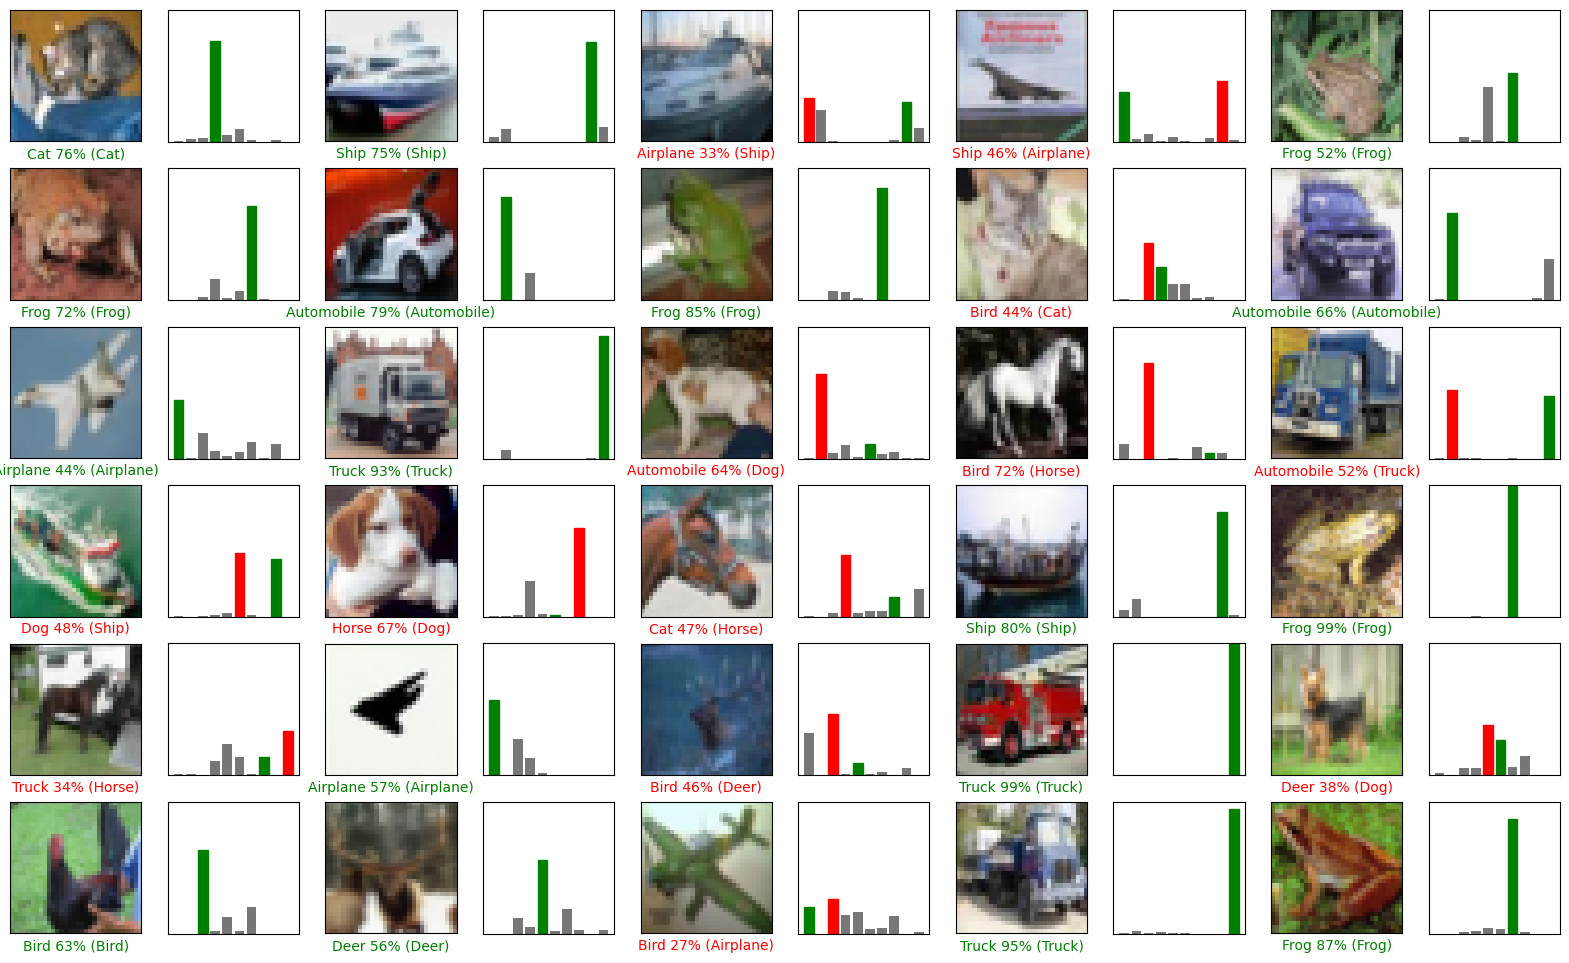

In [22]:
# verification of several images

num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    plot_image(i, predictions, y_test, x_test,class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test, show_x_ticks)

plt.show()



### CNN

In [23]:
def build_cnn_model_cifar(hp):

    pooling_type = hp.Choice(f'pooling_type', values = ['max','avg'])
    filters_1st = hp.Int(f'conv_0_filter', min_value=16, max_value=64, step=16)
    kernel_1st = hp.Choice(f'conv_0_kernel_size', values = [3,5])
    dropout_rate = hp.Choice(name='dropout_layer_rate',values=[0.1, 0.2])
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # create model object
    model = tf.keras.Sequential()
    #adding convolutional layer
    model.add(tf.keras.layers.Conv2D(
        #adding filter
        filters=filters_1st,
        # adding filter size or kernel size
        kernel_size=kernel_1st,
        strides=(1, 1),
        padding='same',
        #activation function
        activation='relu'
    ))
    model.add(tf.keras.layers.Conv2D(
        #adding filter
        filters=filters_1st,
        # adding filter size or kernel size
        kernel_size=kernel_1st,
        strides=(1, 1),
        padding='same',
        #activation function
        activation='relu'
    ))

    model.add(
        tf.keras.layers.BatchNormalization()
    )
    if pooling_type == 'max':
        # add poolling layer
        model.add(tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same'
        ))
    elif pooling_type == 'avg':
        # add poolling layer
        model.add(tf.keras.layers.AveragePooling2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same'
        ))

    for i in range(hp.Int(name='conv_layers',min_value=1,max_value=2)):
        f = hp.Int(f'conv_{str(i+1)}_filter', min_value=16, max_value=64, step=16)
        k = hp.Choice(f'conv_{str(i+1)}_kernel', values = [3,5])
        #adding convolutional layer
        model.add(tf.keras.layers.Conv2D(
            #adding filter
            filters=f,
            # adding filter size or kernel size
            kernel_size=k,
            strides=(1, 1),
            padding='same',
            #activation function
            activation='relu'
        ))
        model.add(tf.keras.layers.Conv2D(
            #adding filter
            filters=f,
            # adding filter size or kernel size
            kernel_size=k,
            strides=(1, 1),
            padding='same',
            #activation function
            activation='relu'
        ))

        model.add(
            tf.keras.layers.BatchNormalization()
        )
        if pooling_type == 'max':
            # add poolling layer
            model.add(tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='same'
            ))
        elif pooling_type == 'avg':
            # add poolling layer
            model.add(tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='same'
            ))


    model.add(tf.keras.layers.Dropout(
        rate=dropout_rate
    ))

    # adding flatten layer
    model.add(tf.keras.layers.Flatten())
    # adding dense layer
    model.add(tf.keras.layers.Dense(
        units=hp.Choice('units', values=[1024, 2048, 4096]),
            kernel_initializer='glorot_uniform',
            activation='relu'
    ))

    model.add(tf.keras.layers.Dropout(
        rate=dropout_rate
    ))

    # output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    #compilation of model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [24]:
tuner = kt.Hyperband(build_cnn_model_cifar,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     seed=42,
                     project_name='deep_cifar_2')

In [25]:
reduce_lr_plateau = ReduceLROnPlateau(
        monitor = 'val_accuracy',
        factor = 0.1,
        patience = 2,
        min_delta = 0.0001,
        cooldown = 0,
        min_lr = 0
)

In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [27]:
tuner.search(x_train, y_train, batch_size=2048,
             epochs=50, validation_split=0.2,
             callbacks=[early_stopping])


Trial 30 Complete [00h 04m 08s]
val_accuracy: 0.756600022315979

Best val_accuracy So Far: 0.7720999717712402
Total elapsed time: 00h 41m 56s


In [28]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'conv_0_kernel': 'avg',
 'conv_0_filter': 16,
 'conv_0_kernel_size': 3,
 'dropout_layer_rate': 0.1,
 'learning_rate': 0.001,
 'conv_layers': 2,
 'conv_1_filter': 48,
 'conv_1_kernel': 5,
 'units': 4096,
 'conv_2_filter': 16,
 'conv_2_kernel': 5,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [33]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
cnn_model = tuner.hypermodel.build(best_hps)
#cnn_model.summary()

In [35]:
cnn_history = cnn_model.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1250/1250 [==============================] - 12s 9ms/step - loss: 1.4440 - accuracy: 0.4796 - val_loss: 1.1323 - val_accuracy: 0.5938
Epoch 2/50
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0425 - accuracy: 0.6318 - val_loss: 0.9870 - val_accuracy: 0.6496
Epoch 3/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8645 - accuracy: 0.6961 - val_loss: 1.0559 - val_accuracy: 0.6408
Epoch 4/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.7456 - accuracy: 0.7355 - val_loss: 0.8178 - val_accuracy: 0.7185
Epoch 5/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.6328 - accuracy: 0.7768 - val_loss: 0.8187 - val_accuracy: 0.7290
Epoch 6/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5552 - accuracy: 0.8056 - val_loss: 0.8452 - val_accuracy: 0.7190
Epoch 7/50
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4818 - accuracy: 0.8309 - val_loss: 0.8022 - val_accuracy

In [37]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 average_pooling2d_6 (Avera  (None, 16, 16, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 48)        19248     
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 48)       

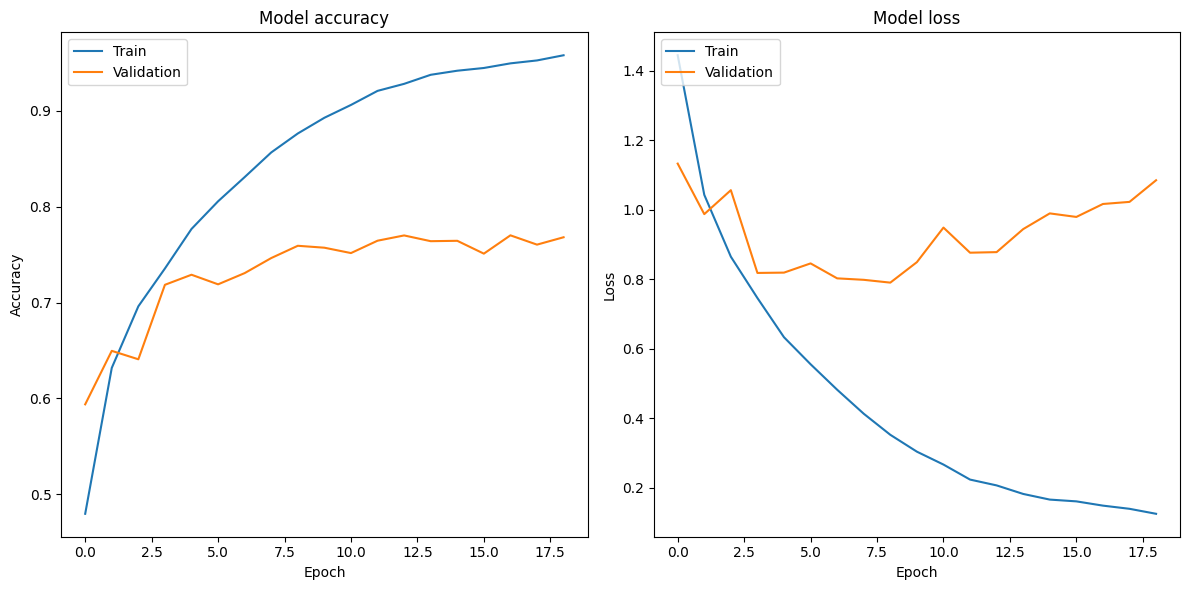

In [36]:
plot_training_curves(cnn_history)

In [41]:
cnn_model.save("cifar_cnn_best_model.h5")

In [44]:
# test the model on testing data
eval_result = cnn_model.evaluate(x_test, y_test, verbose = 1)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 7ms/step - loss: 0.8344 - accuracy: 0.7466
[test loss, test accuracy]: [0.8344054818153381, 0.7465999722480774]


In [47]:
# predictions = np.argmax(model.predict(X_test), -1)
predictions = cnn_model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions,-1), target_names=class_names))

313/313 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

    Airplane       0.70      0.83      0.76      1000
  Automobile       0.80      0.93      0.86      1000
        Bird       0.65      0.66      0.65      1000
         Cat       0.59      0.50      0.54      1000
        Deer       0.80      0.63      0.70      1000
         Dog       0.64      0.68      0.66      1000
        Frog       0.87      0.76      0.81      1000
       Horse       0.75      0.81      0.78      1000
        Ship       0.84      0.85      0.85      1000
       Truck       0.84      0.81      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



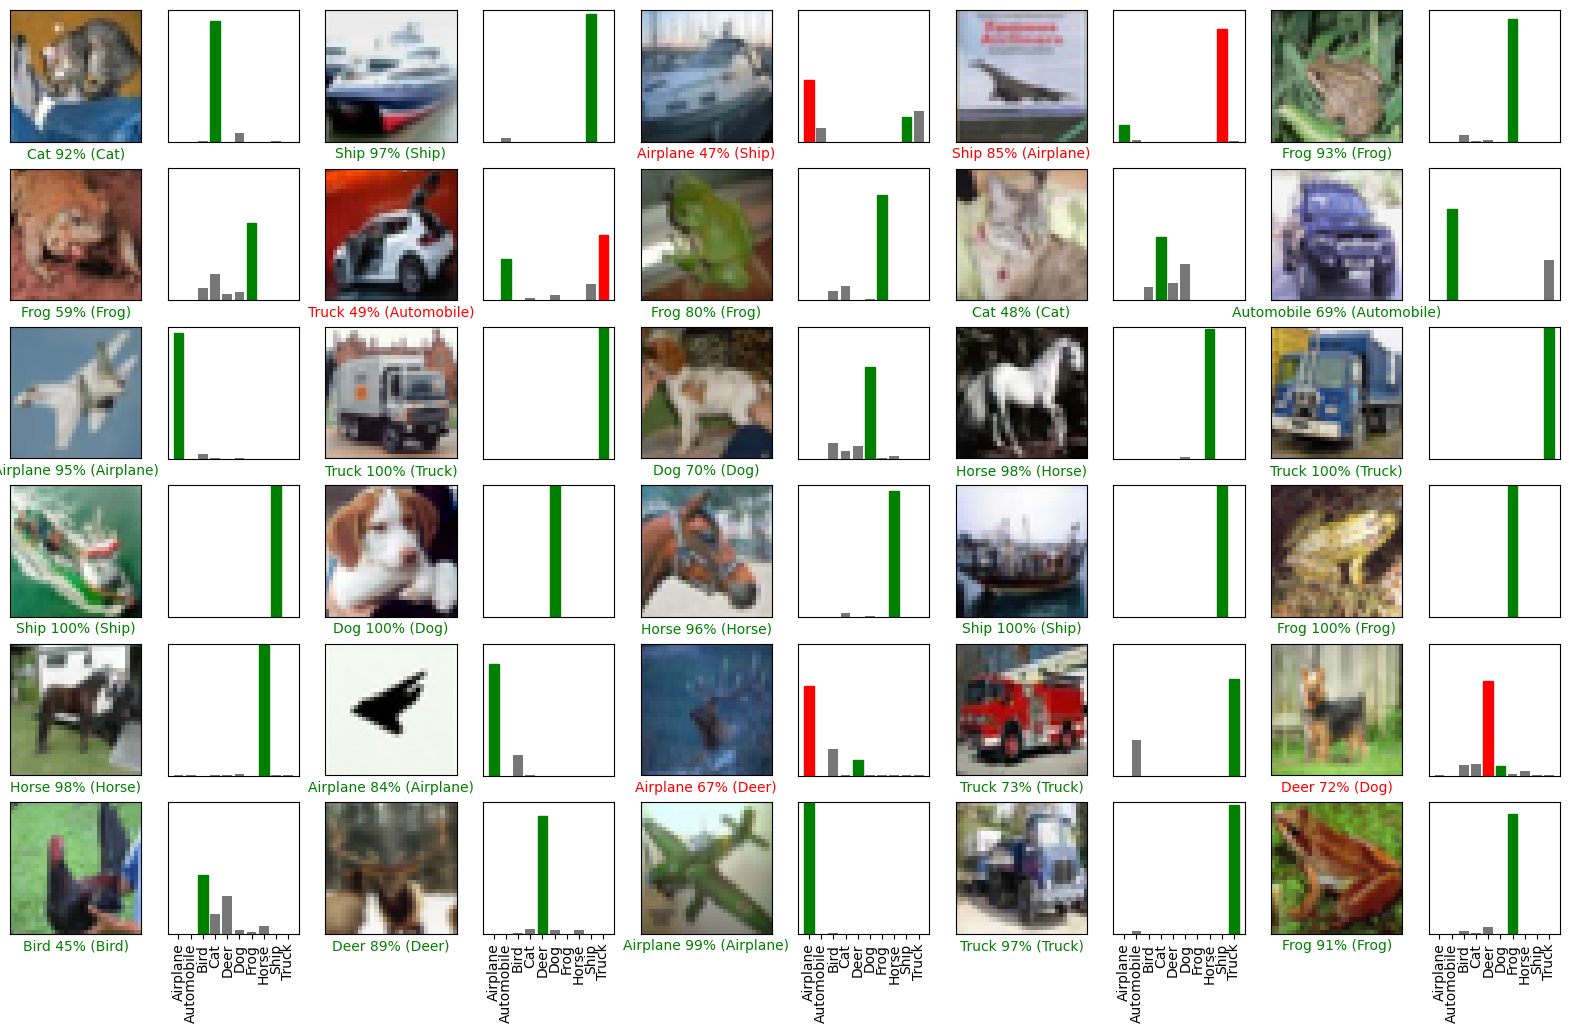

In [49]:
# verification of several images

num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    plot_image(i, predictions, y_test, x_test, class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test, class_names,show_x_ticks)

plt.show()


In [5]:
for i in range(len(cnn_model.layers)):
    layer = cnn_model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)



0 conv2d_16 (None, 32, 32, 16)
1 conv2d_17 (None, 32, 32, 16)
4 conv2d_18 (None, 16, 16, 48)
5 conv2d_19 (None, 16, 16, 48)
8 conv2d_20 (None, 8, 8, 16)
9 conv2d_21 (None, 8, 8, 16)


In [6]:
# redefine model to output right after the first hidden layer
model_tmp = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[1].output)

In [7]:
img = np.expand_dims(x_test[0], axis=0)

2024-03-23 03:32:33.584696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 395ms/step


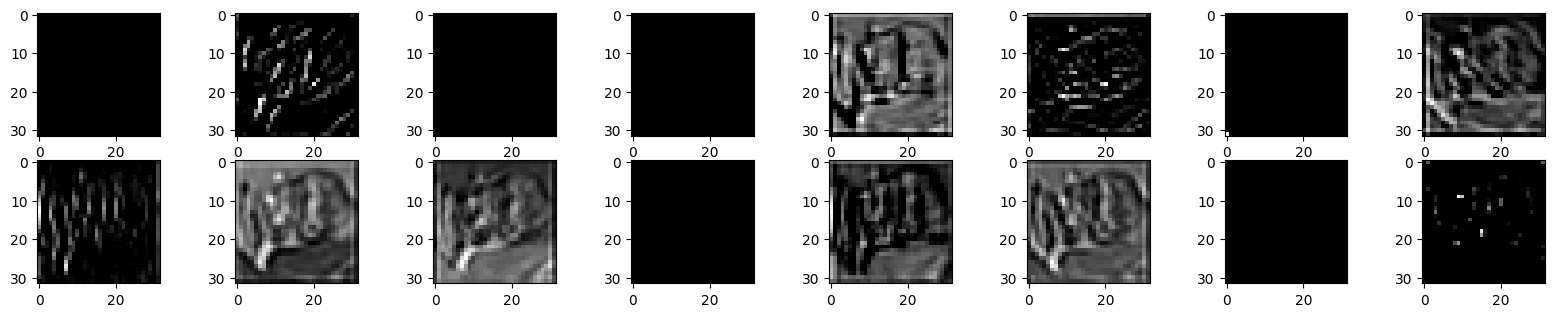

In [8]:
#calculating features_map
features = model_tmp.predict(img)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()



In [9]:
layers = [ 0, 1 , 4 , 5 , 8, 9]
outputs = [cnn_model.layers[i].output for i in layers]

model_tmp2 = Model( inputs= cnn_model.inputs, outputs = outputs)

1/1 [==============================] - 0s 302ms/step


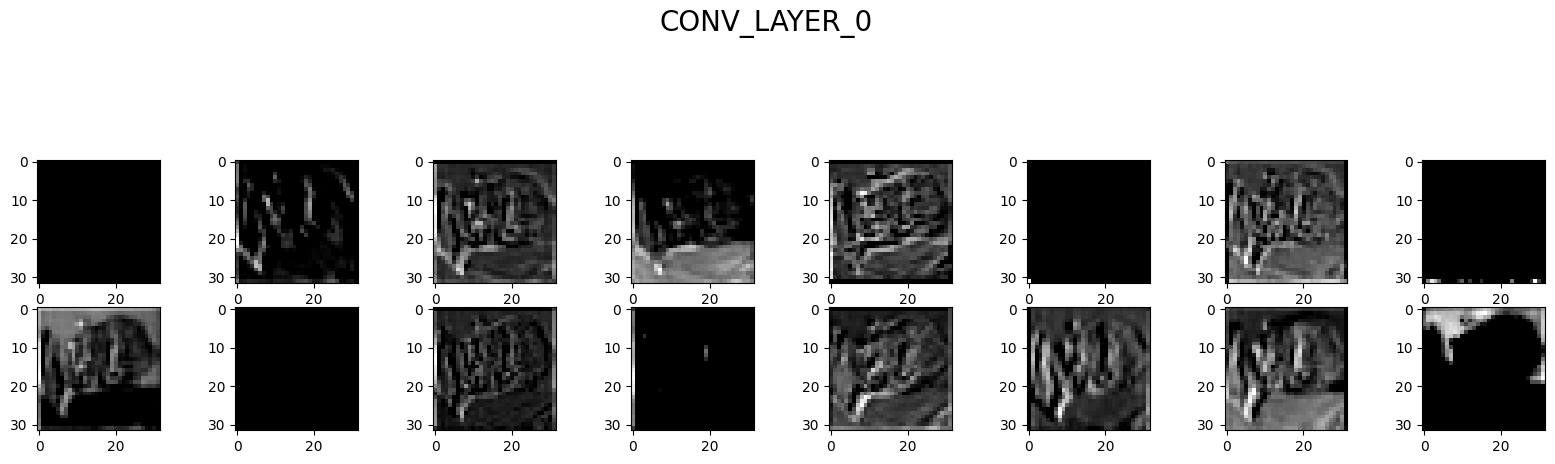

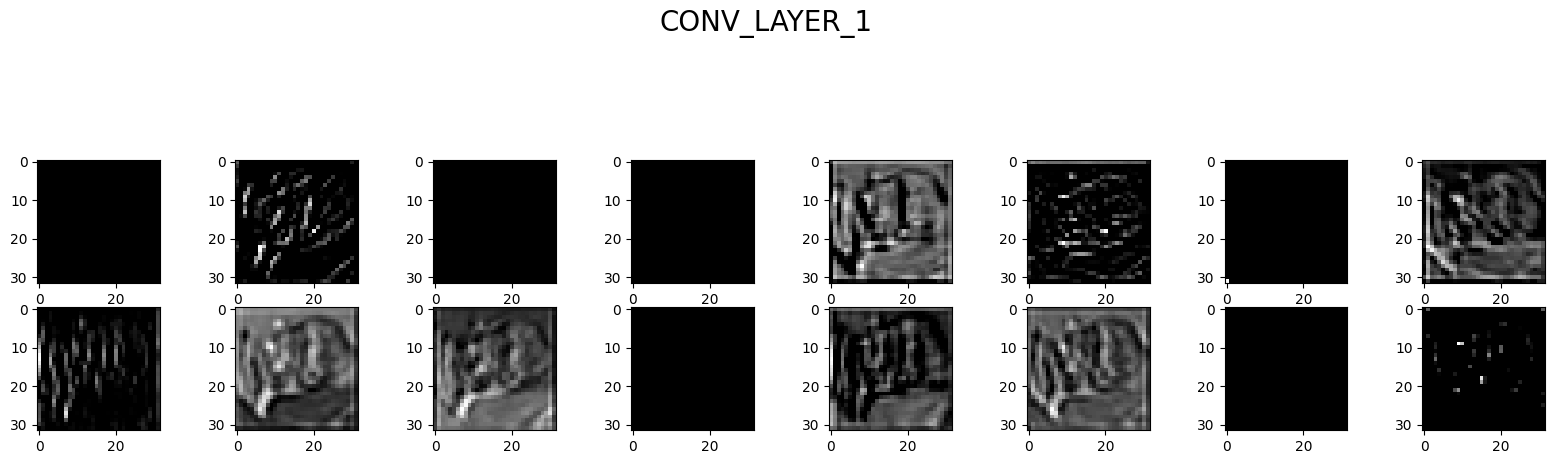

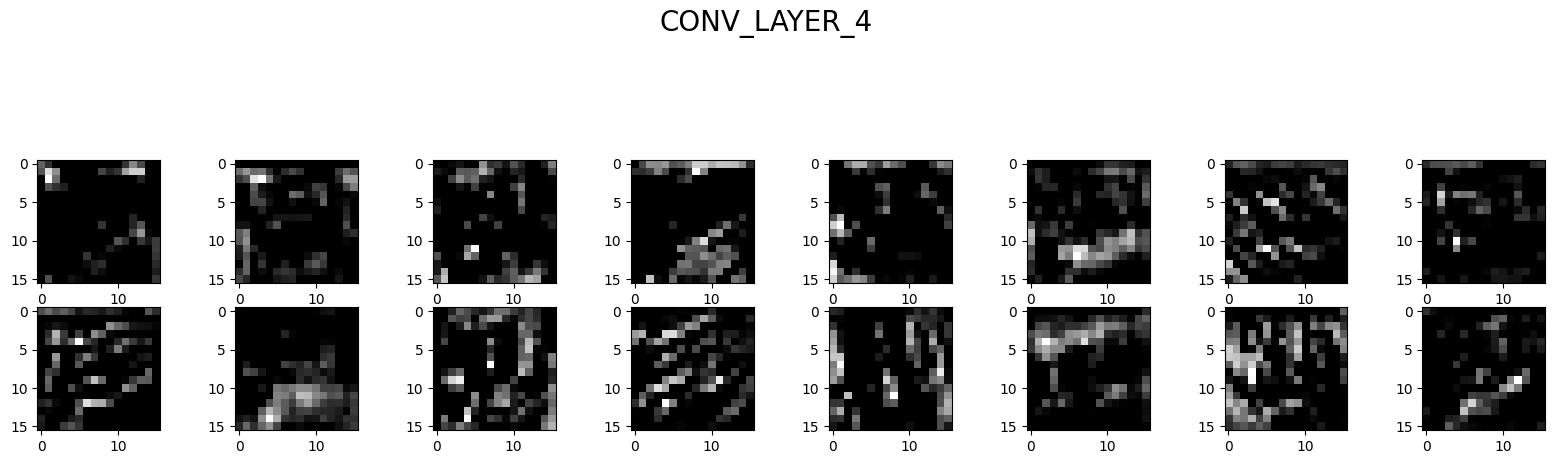

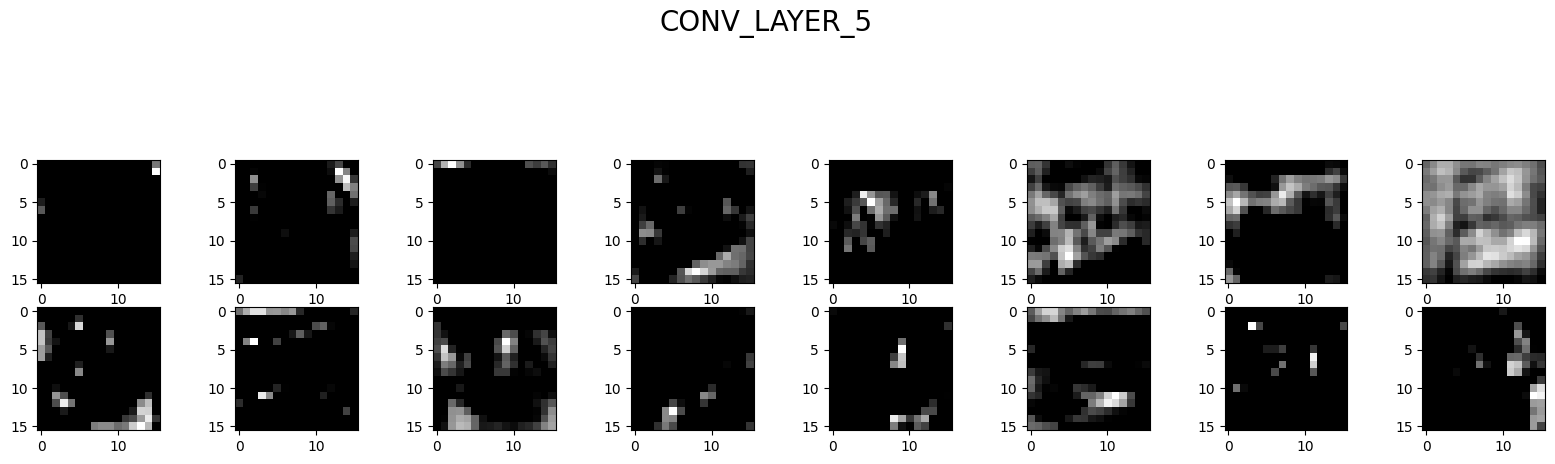

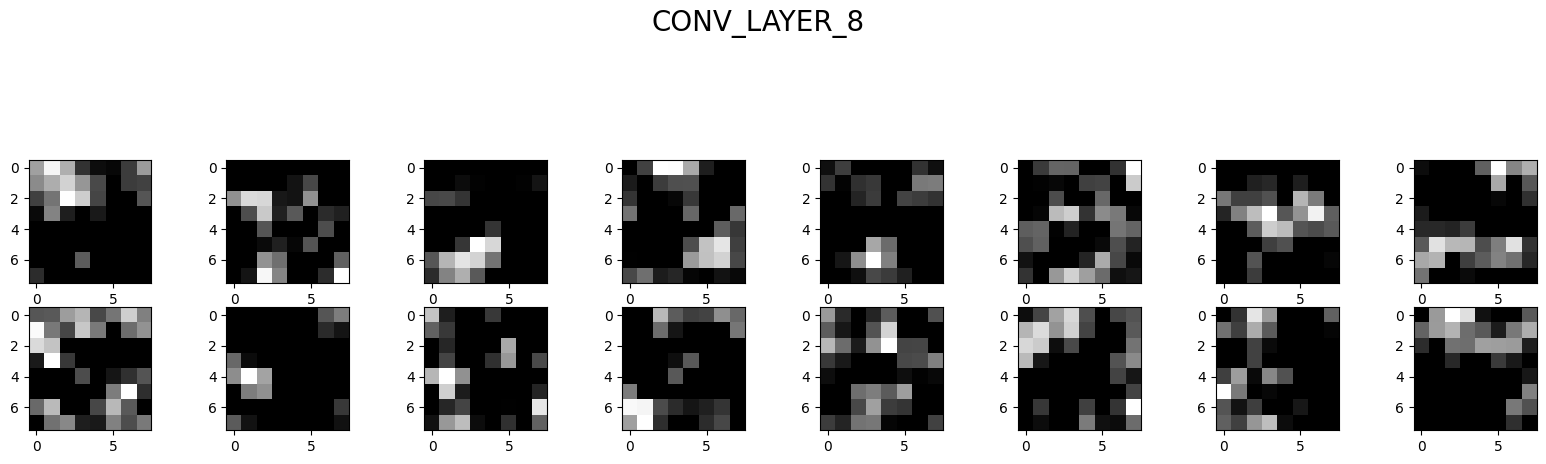

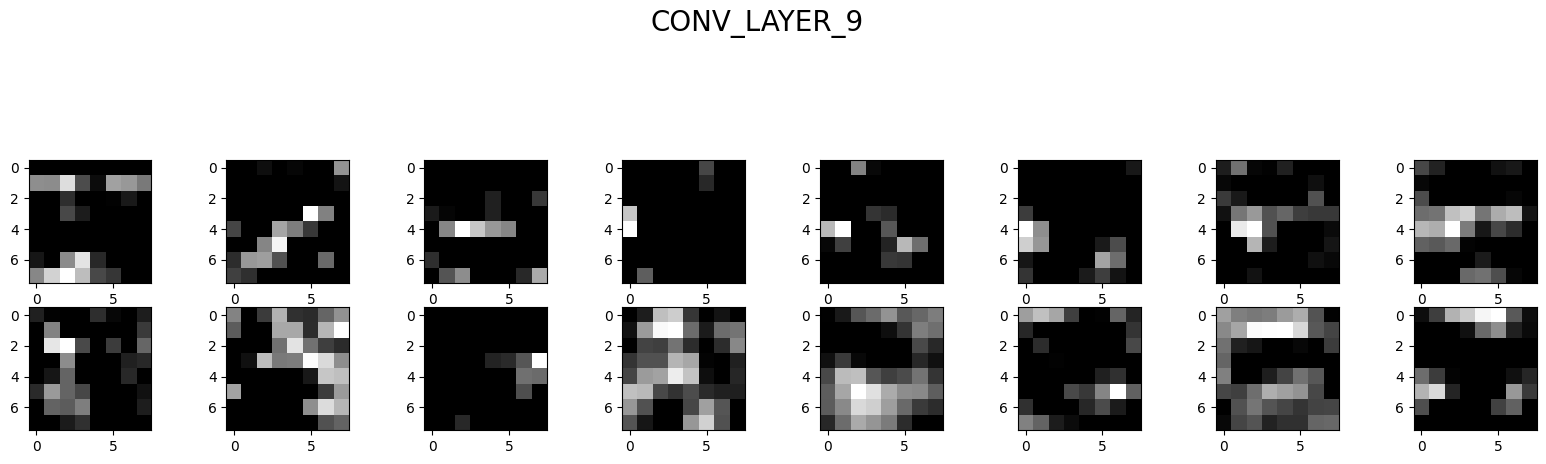

In [10]:
feature_map = model_tmp2.predict(img)

for i,fmap in zip(layers,feature_map):
    fig = plt.figure(figsize=(20,15))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("CONV_LAYER_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')
    
plt.show()